# Forecasting Customer Lifetime Value

On the previous topic of this series, I explained [Why Uncertainty Matters](https://raphaeltamaki.github.io/raphaeltamaki/posts/Forecasting%20Customer%20Lifetime%20Value%20-%20Why%20Uncertainty%20Matters/) in for marketing, and how one should adapt the bidding to different degrees of Lifetime Value uncertainty and user acquisition response to the bid. In this part, we show how to obtain the customer Lifetime Value (LTV) and its uncertainty estimates by using PySTAN or PyMC.

We will rely on the [Lifetime Value data from Kaggle](https://www.kaggle.com/datasets/baetulo/lifetime-value?resource=download) as the base for this exercise. This dataset is structured with the intent to predict the Lifetime Value of users using some short-term engagement information about them, which can be accomplished using a supervised algorithm such as XGBoost. We use CatBoost but any other boosted tree based algorithm should perform similarly, especially since we won't focus in hyperparameter tuning or feature engineering.

However, when we are dealing with marketing campaigns, we are not as interested in the Lifetime Value of users that already got acquired as much as forecasting the Lifetime Value of the users to come. Afterall, from a tactic point of view, the only lever that User Acquisition can have in the profitability of the company is on correctly bidding on the users that are to come. 

But as these users don't yet exist, we don't have any short-term engagement information about them, just some generic demographic information, which can vary depending on the advertisement platform. For example, in Facebook one can specifically target people based on interests, device, or some other demographic information such as age and gender. Still, the point holds: we don't have engagament or other user specific information.

So, when dealing with LTV estimation for marketing campaigns we need to predict the **expected** value of the targeted population, not the **sample** of the population that we have data on.  



This session is divided in 7 different sections:
1) Import libraries
2) Data load, and analysis: we start by loading the [Lifetime Value data from Kaggle](https://www.kaggle.com/datasets/baetulo/lifetime-value?resource=download) and running some lightweight data inspection before we start modelling
3) Predicting LTV of existing users: we create a baseline model using XGBoost with default parameters on the data
4) Preparation into time-series: we transform the user-level data into a segment level data, with time-series prediction of LTV for every segment
5) Modelling the time-series: we introduce the model (a Gaussian Random Walk) and the implementation in PySTAN
6) Common pitfall: we show common errors that people stumble on
7) Extra: Implementing the time-series model in PyMC, PyMC and PySTAN Benchmark, 

## 1- We install (and call) all the required libraries
This is here mostly just to serve as a reference for almost all the libraries that will be used. All of the libraries here can be installed using pip, but while PySTAN can also be installed with pip, you may have to install STAN through some other mean

In [1]:
# nest_asyncio is needed for running pystan in a notebook
import nest_asyncio
nest_asyncio.apply()

In [2]:
import stan
import pandas as pd
import numpy as np
import pymc as pm
import pytensor
import seaborn as sns
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression


sns.set_style('whitegrid')
rng = np.random.default_rng(42)
PLOT_WITHD_INCHES = 20
PLOT_HEIGHT_INCHES = 10

# 2- Data load, analysis, and preparation

## 2.1- Loading the data

We load the training dataset from the Lifetime Value dataset from Kaggle: https://www.kaggle.com/datasets/baetulo/lifetime-value?select=train.csv

This dataset has the most important characteristics in digital marketing: 
- it is zero(ish)-inflated (i.e. it has a large number of users with LTV $0 or close to 0), and
- the non-zero values follow a distribution with a long tail

To simulate a marketing campaign, we group the users by randomly sampling them without replacement and make the sample size to be quite small at 200 users per day, on average. We set the number of users per day to be small (at least small compared to how many users we have available) to more closely represent a challenging marketing campaign scenario, where the LTV can strongly vary.

In [3]:
!kaggle datasets download -d baetulo/lifetime-value

 47%|██████████████████                    | 5.00M/10.5M [00:00<00:00, 21.7MB/s]
100%|██████████████████████████████████████| 10.5M/10.5M [00:00<00:00, 32.4MB/s]


In [4]:
!unzip -j lifetime-value.zip 

Archive:  lifetime-value.zip
  inflating: test.csv                
  inflating: train.csv               


In [5]:
!rm lifetime-value.zip test.csv

In [6]:
data = pd.read_csv('train.csv')

In [7]:
data.head()

,product_type,user_id,join_date,hidden,product,STV,target,credit_card_level,is_lp,aff_type,is_cancelled,country_segment
0,type_ex,7.0,2018-12-01 00:01:45,0,product_1,8.25,8.25,standard,0,PPL,NaN,US
1,type_ex,20.0,2018-12-01 00:06:05,0,product_2,8.25,8.25,standard,0,PPL,NaN,US
2,type_ex,22.0,2018-12-01 00:06:23,0,product_3,8.25,8.25,prepaid,0,PPL,NaN,US
3,type_ex,26.0,2018-12-01 00:07:12,0,product_2,8.25,8.25,standard,0,PPL,NaN,US
4,type_ex,59.0,2018-12-01 00:15:21,0,product_2,8.25,8.25,standard,0,PPL,NaN,Other Countries


## 2.2- Data analysis

Lifetime Value data at user level, often have the following properties:
1) **Zero-inflated**: if we are dealing with LTV of digital products, the digital products (especially mobile products) usually work on a freemium model. In this model, a user is free to use the product though with some limitations, like blocked features. This means that while users will try the product (or be interested interest enough to subscribe, download, participate in a free-trial, etc) few will actually pay for it.
2) **Highly-skewed**: even when we focus on the users who pay for a product, most will pay only a few times, in a subscription based products, or purchase a few low-value items, in In-App Purchase based products. However, there are highly-valuable users who subscrive for long time or that buy many expensive items, and
3) **Pareto distributed**: those high valuable users are often responsible for most of the revenue of a product.

Let's see if those properties can be found on this dataset:

Text(0.0, 1.0, 'Distribution of users Lifetime Value')

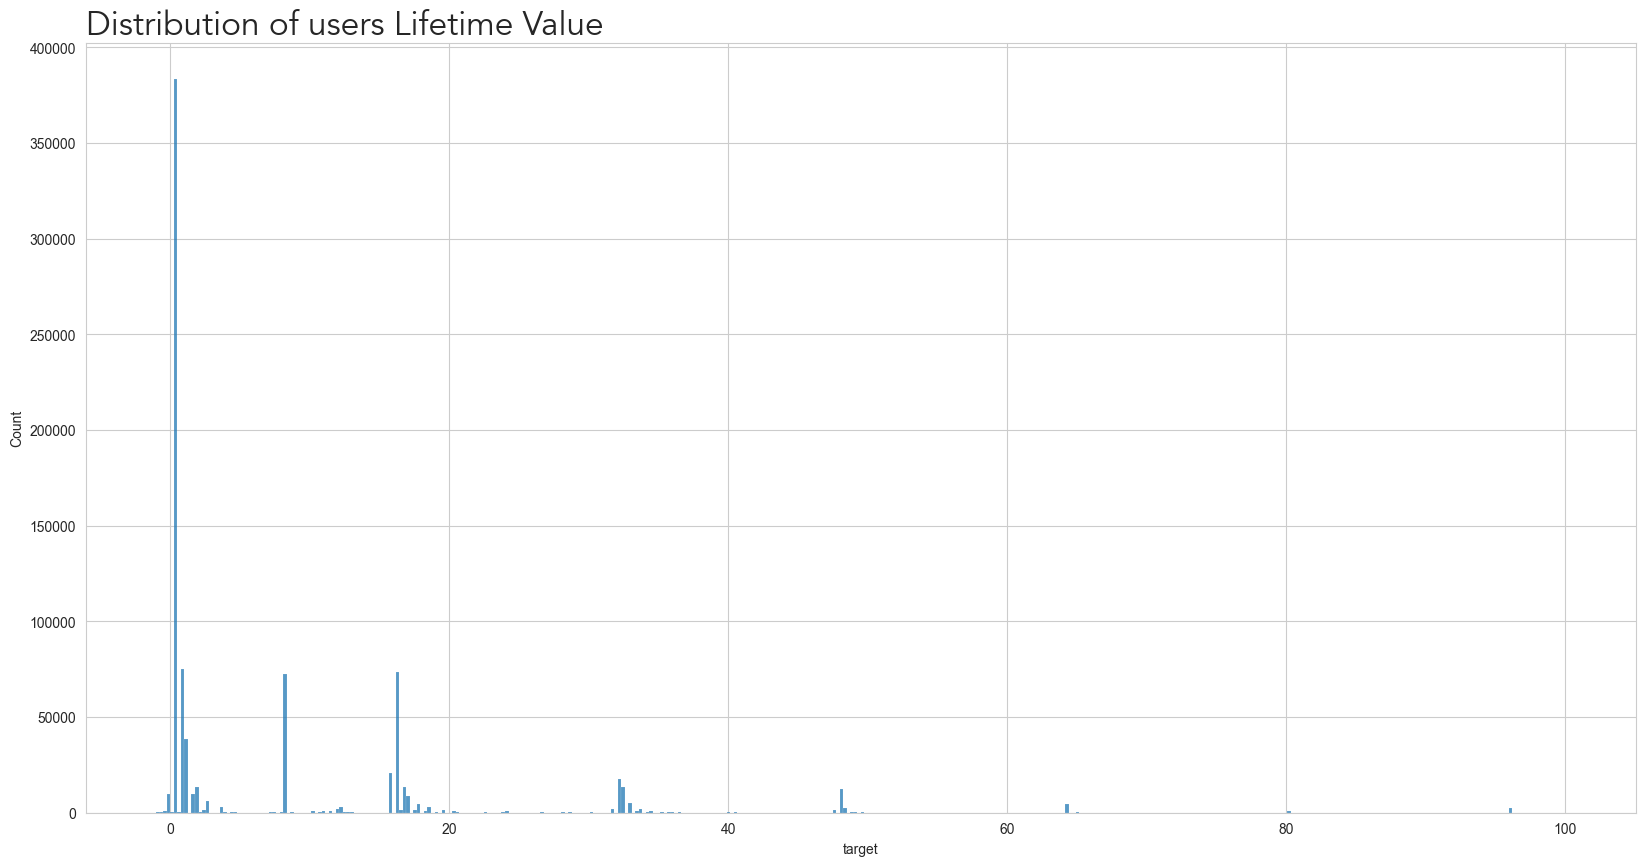

In [8]:
# Let's start looking at the distribution of LTV
grid = sns.histplot(data['target'], binrange=[-1, 100])
grid.figure.set_size_inches(PLOT_WITHD_INCHES, PLOT_HEIGHT_INCHES)
plt.title(
    'Distribution of users Lifetime Value', 
    font='Avenir', 
    fontsize=24, 
    loc='left')

From the distribution of the LTV, it is immediate that the 2 first properties are present: most of the users are valued (almost) nothing, and there are a few users that are worth much more than most, indicated by the presence of users valued close to $100.

Let's now see if the Pareto property is present as well:

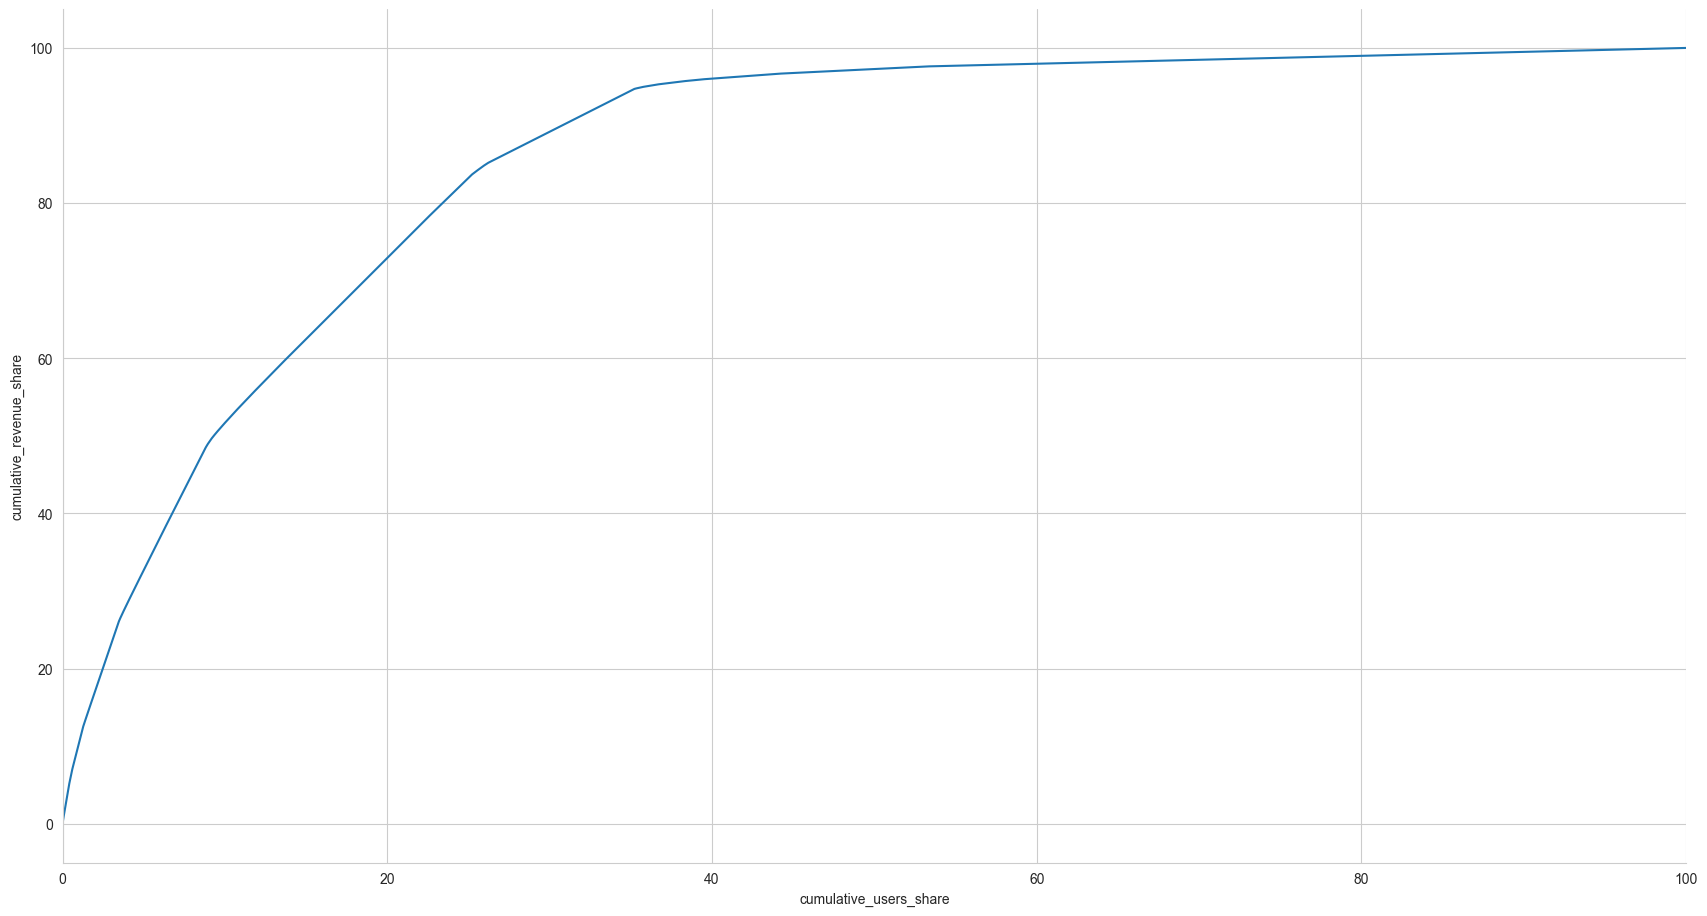

In [9]:
def summary(x):
    output = {}
    output['users'] = len(x['user_id'])
    output['revenue'] = np.sum(x['target'])
    return pd.Series(output)

pareto_data = data.query('target >= 0').groupby(['target']).apply(summary).reset_index()
pareto_data = pareto_data.sort_values(['target'], ascending=False)
pareto_data['cumulative_revenue_share'] = pareto_data['revenue'].cumsum() / pareto_data['revenue'].sum() * 100
pareto_data['cumulative_users_share'] = pareto_data['users'].cumsum() / pareto_data['users'].sum() * 100
pareto_data

grid = sns.relplot(pareto_data, x='cumulative_users_share', y='cumulative_revenue_share', kind='line', facet_kws={'xlim': [0, 100]})
grid.figure.set_size_inches(PLOT_WITHD_INCHES, PLOT_HEIGHT_INCHES)

By ordering in the users by descending LTV, we see that the 20% most valuable users are responsible for 76% of the revenue. This is almost a perfect Pareto relationship.

## 3- Predicting LTV

In [10]:
dates = pd.to_datetime(data['join_date'])

training_period = 60 # train for 60 days
training_start_date = np.min(dates)
training_end_date = training_start_date + timedelta(days=training_period)

# the test period for the model will of 63 days
test_start_date = training_end_date  + timedelta(days=63 - 4)
test_end_date = test_start_date  + timedelta(days=63)

# validation period will be used for the time-series
val_start_date = test_end_date  + timedelta(days=4)
val_end_date = np.max(dates)

print(f"Training period: From {training_start_date} to {training_end_date}")
print(f"Test period: From {test_start_date} to {test_end_date}")
print(f"Validation period: From {val_start_date} to {val_end_date}")

Training period: From 2018-12-01 00:00:04 to 2019-01-30 00:00:04
Test period: From 2019-03-30 00:00:04 to 2019-06-01 00:00:04
Validation period: From 2019-06-05 00:00:04 to 2019-06-30 23:59:56


In [11]:
# Prepare dataset
y = data['target']
X = data.drop(['target', 'user_id', 'join_date'], axis=1)

def encode_categoricals(data: pd.DataFrame):
    from pandas.api.types import is_numeric_dtype
    non_numeric_cols = [
        column for column in list(data.columns) if not is_numeric_dtype(data[column])
    ]
    for column in non_numeric_cols:
        data[column] = data[column].astype("category").cat.codes
    return data

def date_filter(date: pd.Series, start_date, end_date):
    return (dates >= start_date) & (dates <= end_date)


X = encode_categoricals(X)


train_filter = date_filter(dates, training_start_date, training_end_date)
test_filter = date_filter(dates, test_start_date, test_end_date)
val_filter = date_filter(dates, val_start_date, val_end_date)

train_X = X[train_filter]
train_y = y[train_filter]


test_X = X[test_filter]
test_y = y[test_filter]

val_X = y[val_filter]
val_y = y[val_filter]

In [12]:
# We use a XGBRegressor with default hyperparameters
model = XGBRegressor()

# train base model
model.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [13]:
from sklearn.metrics import mean_squared_error
error_variance = mean_squared_error(model.predict(test_X), test_y)

In [14]:
# Remember that for a normal distribution, the mean squared error is the variance
np.std(test_y) - np.sqrt(mean_squared_error(test_y, np.mean(test_y) * np.ones(len(test_y))))

0.0

## 4- Preparation into a time-series


In [15]:
# Constants
def prepare_date(data: pd.DataFrame):
    data['date'] = (pd.to_datetime(data['join_date']) - training_start_date).dt.days
    return data

In [16]:
# group values per day, so that we have a time-series of the average LTV of this product
def summary(x):
    output = {}

    output['users'] = len(x['target'])
    
    # Average and std LTV
    output['avg_target'] = np.mean(x['target'])
    output['sd_avg_value'] = np.std(x['target']) / np.sqrt(len(x['target'])) # stddev of the average, assuming normality
    
    # Average and std predictions
    output['avg_prediction'] = np.mean(x['prediction'])
    output['sd_prediction'] = np.std(x['prediction']) / np.sqrt(len(x['target'])) # stddev of the average, assuming normality
    output['true_sd_error'] = np.std(x['prediction'] - x['target']) / np.sqrt(len(x['target'])) # stddev of the average, assuming normality
    
    # we set the error variance to be that of what we observed during the train period.
    # As this is related to the error at user level, we have to divide py the square root of the number of users
    output['estimated_sd_error'] = np.sqrt(error_variance / output['users'])
    
    # we assume that there is no correlation between the prediction error and the prediction itself
    output['total_sd_prediction'] = np.sqrt(output['sd_prediction']**2 + output['estimated_sd_error']**2)
    return pd.Series(output)


In [17]:
# Create the time-series data for the Test period, which represent the period of time 
# we consider valid to train our time-series model

test_time_series_data = test_X.copy()
test_time_series_data['date'] = (dates[test_filter] - test_start_date).dt.days
test_time_series_data['prediction'] = model.predict(test_X)
test_time_series_data['target'] = test_y

test_time_series_data = test_time_series_data.groupby(['date']).apply(lambda x: summary(x)).reset_index()
test_time_series_data.head()

,date,users,avg_target,sd_avg_value,avg_prediction,sd_prediction,true_sd_error,estimated_sd_error,total_sd_prediction
0,0,4639.0,6.323679,0.227428,6.735502,0.126238,0.196348,0.187880,0.226351
1,1,5045.0,6.715325,0.220810,6.966258,0.128640,0.189552,0.180162,0.221374
2,2,4740.0,6.823155,0.216144,6.902818,0.130749,0.180993,0.185868,0.227249
3,3,4216.0,7.032902,0.255530,7.281071,0.150984,0.211738,0.197080,0.248267
4,4,4289.0,6.619117,0.235460,6.919528,0.138276,0.197603,0.195396,0.239374


<Axes: xlabel='date', ylabel='avg_prediction'>

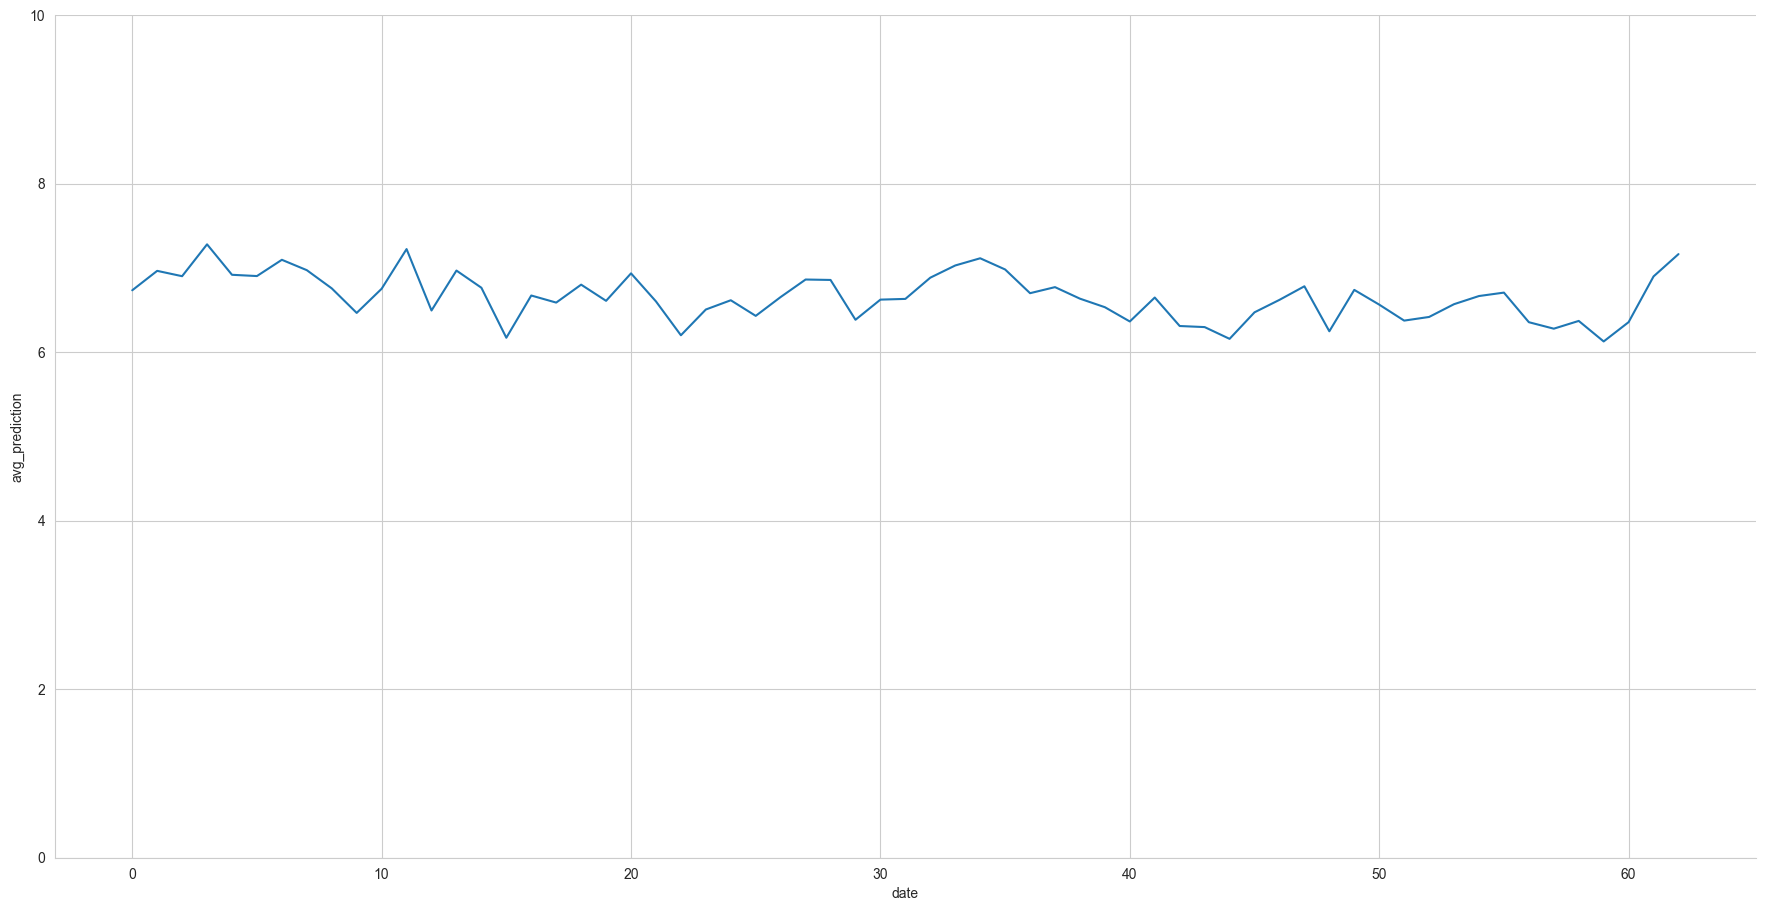

In [18]:
g = sns.relplot(test_time_series_data, x='date', y='avg_prediction', kind='line', facet_kws={'ylim': [0, 10]})
g.figure.set_size_inches(20, 10)
g.ax

## 5- Model the time series as a Gaussian Random Walk in PySTAN

Now we just have to define the Stan model. When using PySTAN what you do is pass the exact code that Stan should use, which is why it is passed as a string. The grammar and structure are quite straightforward, with examples being abundant, and error messages being informative.

The steps to model the data are:
1) define the stan model
2) prepare the data for stan (it has to be passed as a dict
3) train the model (can take a long time, since it is estimate a distribution for each point)
4) visualize results

### 5.1- Define the Stan Model

For this case, the Stan model is pretty straightforward. The Stan model is divided into 'blocks' defined by the brackets "{}". There are mainly 3 building blocks
- **data**: which defines Stan values that are inputs and will be used to estimate the parameters of the model
- **parameters**: as you would expect by the name, are the parameters of the model you want to build
- **model**: is where you describe how the data and the parameters are connected

In this example, we just have 2 parameters that we want to estimate:
- `nu`, which contains the distribution of the expected LTV of each day
- `random_walk_stddev`, which estimates the variance of the random walk and needs to be positive

As this is a bayesian model, we always need to define priors for our variables:
- for `random_walk_stddev`, we define a fairly weak prior following a Cauchy distribution with parameters 0 and 2
- for the first element of the random walk `nu`, we also define a week prior following a normal distribution with mean 6 and standard deviation 3. Notice that this is the prior for the random walk, not for the LTV distribution of each day
- the LTV of each day is defined on the last line, which we state is normally distributed, with the expected value being the same as our random walk on a specific day and with standard deviation being what we measured to be based on the user-level LTV and the number of users on each day

In [19]:
time_series_model = """
data {
  int<lower=0> N;
  vector[N] sampled_value;
  vector[N] sampling_stddev;
}
parameters {
    vector[N] nu; //The random-walking expected value
    real<lower=0.001> random_walk_stddev; // Standard deviation of random walk
}

model {
    random_walk_stddev ~ cauchy(0, 2); // Define the prior for the random walk stddev
    nu[1] ~ normal(6, 3); // initalize at a point with a fairly weak prior, but far from the truth, just to see convergence
    for (n in 2:N) {
        nu[n] ~ normal(nu[n-1], random_walk_stddev);
    }
    sampled_value ~ normal(nu, sampling_stddev);
}
"""

### 5.2- Prepare data for PySTAN

PySTAN requires that the data be passed as a dictionary, with the keys matching the names defined in the `data` block of the model. In addition, the values on the keys should match the format and variable type defined by the model, which means that the value `N` needs to be a single numeric value instead of a list/array

In [20]:
stan_format_data = {}
stan_format_data['ts']= list(test_time_series_data['date'].values)
stan_format_data['sampled_value']= list(test_time_series_data['avg_prediction'].values)
stan_format_data['sampling_stddev']= list(test_time_series_data['total_sd_prediction'].values)
stan_format_data['N']= test_time_series_data.shape[0]

### 5.3- Train the model

In [21]:
# train the model
start_time = time.time()
# pass the model to STAN (doesn't 'train the model' per say)
posterior = stan.build(time_series_model, data=stan_format_data)
# sample (is the actually 'fit')
fit = posterior.sample(num_chains=4, num_samples=1000)
print(f"Training the model took {time.time() - start_time} seconds")

Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   6% (500/8000)
Sampling:  16% (1300/8000)
Sampling:  41% (3300/8000)
Sampling:  66% (5300/8000)
Sampling:  85% (6800/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.26 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!


Training the model took 2.9114058017730713 seconds


### 5.4- Visualize predictions

We extract the estimated parameters from the model as a Pandas data frame.
However, in the true fashion of statistical modeling, what we get is not a single value for each parameter. Instead, each row represents a sample from our simulation

As we are (for now) interested only in the expected value of the LTV for each day, we
- only select the columns starting with 'nu.'. Vector parameters in PySTAN have the positions of the elements explicit after a "."
- we calculate the mean (and standard deviation) for each day, then finally
- we combine with the original data to obtain a visualization of how our model fared

In [22]:
model_data = fit.to_frame()  # get the samples from the estimated distribution of each parameter to a pandas DF
model_data.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,nu.1,nu.2,nu.3,...,nu.55,nu.56,nu.57,nu.58,nu.59,nu.60,nu.61,nu.62,nu.63,random_walk_stddev
draws,,,,,,,,,,,,,,,,,,,,,
0,77.294767,0.949738,0.158054,6.0,63.0,0.0,-51.783079,7.023799,7.089262,7.095640,...,6.484335,6.481840,6.374042,6.314059,6.296730,6.280750,6.401130,6.323081,6.526217,0.105230
1,129.186735,0.430508,0.160719,6.0,63.0,0.0,-96.138692,6.862506,6.858168,6.871825,...,6.433357,6.421974,6.471585,6.382237,6.440639,6.486797,6.633632,6.726772,6.774295,0.051705
2,164.298827,0.334734,0.134225,4.0,31.0,0.0,-125.449933,6.745550,6.789835,6.769311,...,6.513530,6.479013,6.517500,6.537147,6.521798,6.541469,6.522448,6.533797,6.537180,0.028261
3,111.577433,0.293781,0.212729,4.0,31.0,0.0,-81.763467,7.029724,7.143597,7.024530,...,6.558935,6.546915,6.540620,6.509928,6.571251,6.512858,6.595835,6.647102,6.677111,0.066685
4,76.188377,0.994335,0.158054,6.0,63.0,0.0,-42.879528,6.560270,6.715380,6.939991,...,6.634236,6.647340,6.576376,6.571420,6.643245,6.583523,6.672808,6.683945,6.907393,0.127373


In [23]:
# Get the average and stddev of the estimates on each day (each one of the nu.{NUMBER})
columns_ = model_data.reset_index().columns
columns_ = [x for x in columns_ if 'nu' in x]
simp_model_data = model_data[columns_]
avgs = np.mean(simp_model_data, axis=0).values

plot_data = pd.DataFrame(
    {
        'date': test_time_series_data['date'],
        'estimated_value': avgs
    },
    columns=['date', 'estimated_value']
)

# create a data to plot the estimated value, the observed value, and the 'true' value
plot_data = pd.merge(test_time_series_data, plot_data, on='date')
# create a moving average as a reference
plot_data['moving_average'] = plot_data.sort_values('date')['avg_prediction'].rolling(window=7).mean()
plot_data = plot_data[['date', 'estimated_value', 'avg_prediction', 'moving_average']]
plot_data = pd.melt(plot_data, id_vars='date', value_vars=['estimated_value', 'avg_prediction', 'moving_average'])

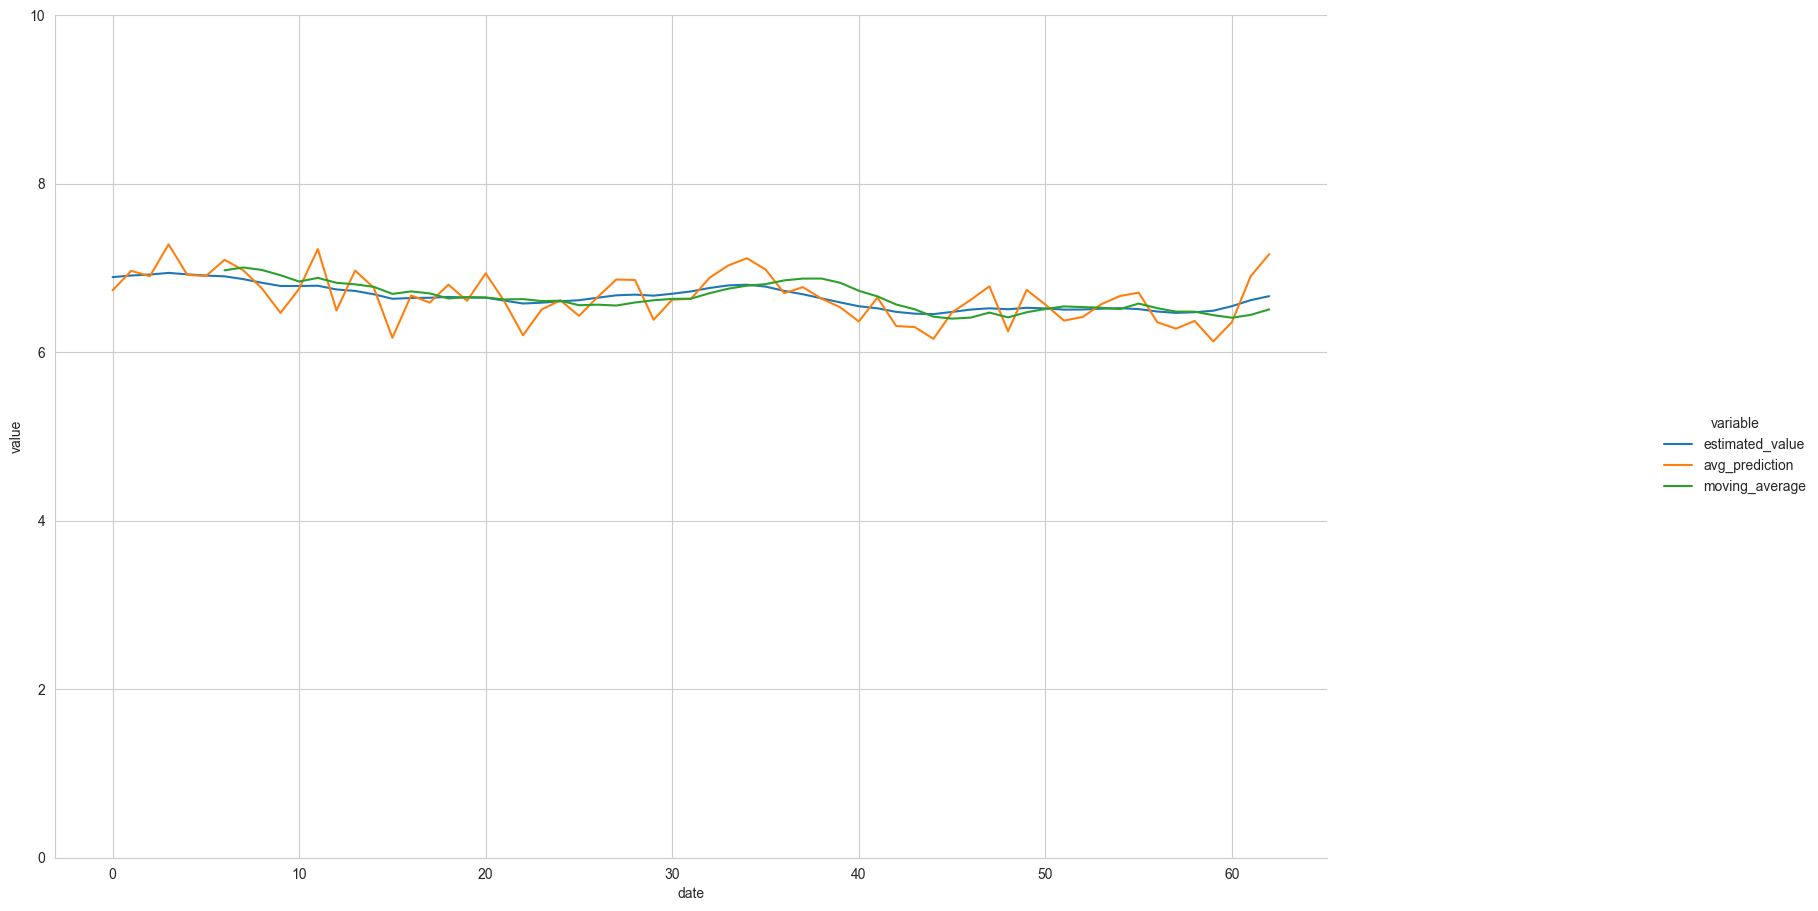

In [24]:
g = sns.relplot(plot_data, x='date', y='value', hue='variable', kind='line', facet_kws={'ylim': [0, 10]})
g.figure.set_size_inches(20, 10)

You see here that the algorithm found the value for the random walk variance that makes the data fit the best. In this case, as there isn't much variation over time and the data does appear to vary over a constant value, the random walk variance was estimated to be very small.

Now let's observe how it performed on the validation period:

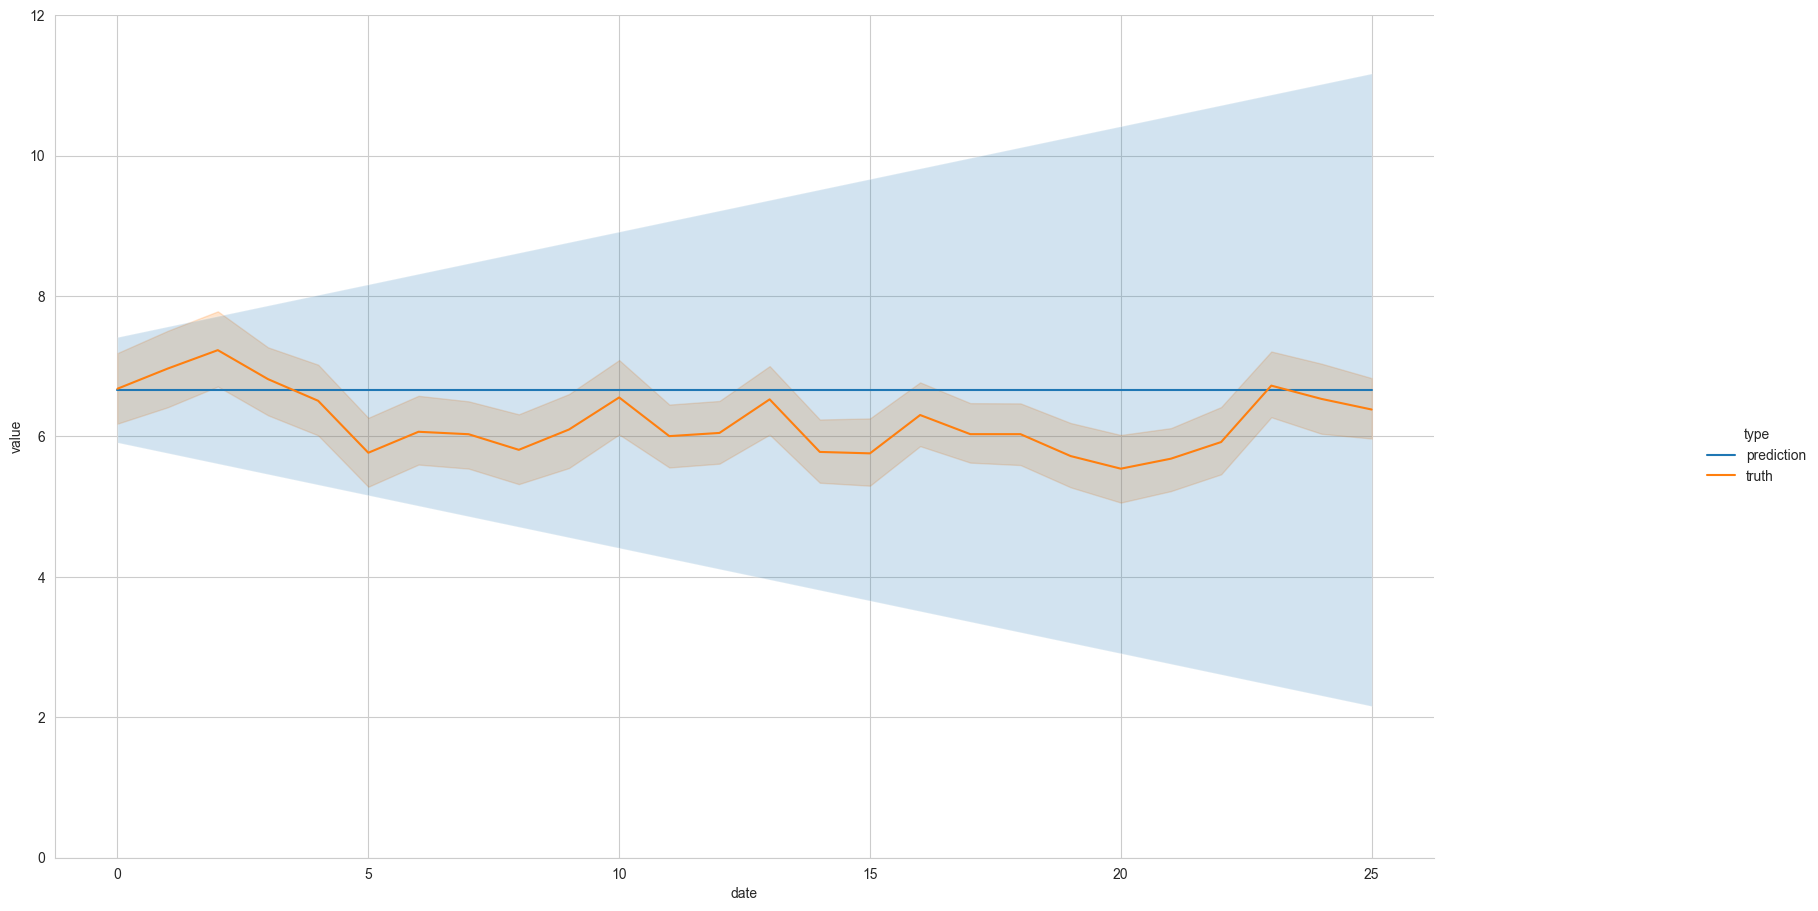

In [25]:
random_walk_std = model_data['random_walk_stddev'].mean()

# Obtain the 'prediction' for the next period, which is simply the last predicted point in a Random Walk
val_days = (val_end_date - val_start_date).days
output = pd.DataFrame(
    {
        "date": np.linspace(0, val_days, val_days),
        "value": np.ones(val_days) * avgs[-1]
    }
)
output['type'] = 'prediction'

# Extact the time-series for the validation period
val_time_series_data = pd.DataFrame({
    'date': (dates[val_filter] - val_start_date).dt.days,
    'value': val_y
})
val_time_series_data['type'] = 'truth'


comparison_date = pd.concat([output, val_time_series_data])

g = sns.relplot(comparison_date, x='date', y='value', hue='type', kind='line', facet_kws={'ylim': [0, 12]})
g.figure.set_size_inches(20, 10)

# add the 95% confidence region
# the last point in the test period is actually 4 days before the first day on the validation period
output['low'] = output['value'] - 1.96 * random_walk_std * (4 + 1 + output['date'])
output['high'] = output['value'] + 1.96 * random_walk_std * (4 + 1 + output['date'])
plt.fill_between(output['date'], output['low'], output['high'], alpha=0.2)
plt.show()

## 6- A critical point to be aware of when using PySTAN (or PyMC) for forecasting

While both models performed well for our purpose, it is important to know that all points in the Gaussian Random Walk modeled by PySTAN or PyMC use **all** of the data points of the time series when 'fitting'. **This means that all the estimated values but the very last point cannot be used to estimate the performance of the model.** If we need to evaluate the performance of the model for each day, we have to train N models, one for each day, repeating the whole process

This happens because, in essence, this model of ours is a hierarchical multi-level gaussian model, in which each 'level' is a date. In a hierarchical multi-level model each layer/level of the model impacts the estimated value of its preceding and following layers.

We demonstrate this point by changing the data to simulate a step signal: it is constant for half of the time after which it immediately changes to a different constant value.

In [26]:
# Change the data to be step-like 
# Define the data to be a step
n_days = 140
before_step_days = 70
after_step_days = n_days - before_step_days
before_value = 9
after_value = 2

step_time_series_data = pd.DataFrame(
    {
        'join_date': np.linspace(1, n_days, num=n_days),
        'sampled_value': np.concatenate([np.full(before_step_days, before_value), np.full(after_step_days, after_value)]),
        'sampling_stddev': np.full(n_days, 0.1)
    }
)

step_format_data = {}
step_format_data['joined_date']= list(step_time_series_data['join_date'].values)
step_format_data['sampled_value']= list(step_time_series_data['sampled_value'].values)
step_format_data['sampling_stddev']= list(np.sqrt(step_time_series_data['sampling_stddev'].values))
step_format_data['N']= step_time_series_data.shape[0]

In [27]:
# Create a replica of the last model and train it
step_model = time_series_model

# train the model
start_time = time.time()
# pass the model to STAN (doesn't 'train the model' per say)
posterior = stan.build(step_model, data=step_format_data)
# sample (is the actually 'fit')
fit = posterior.sample(num_chains=4, num_samples=1000)
print(f"Training the model took {time.time() - start_time} seconds")

Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:  10% (800/8000)
Sampling:  35% (2800/8000)
Sampling:  60% (4800/8000)
Sampling:  85% (6800/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 3.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!


Training the model took 2.747713088989258 seconds


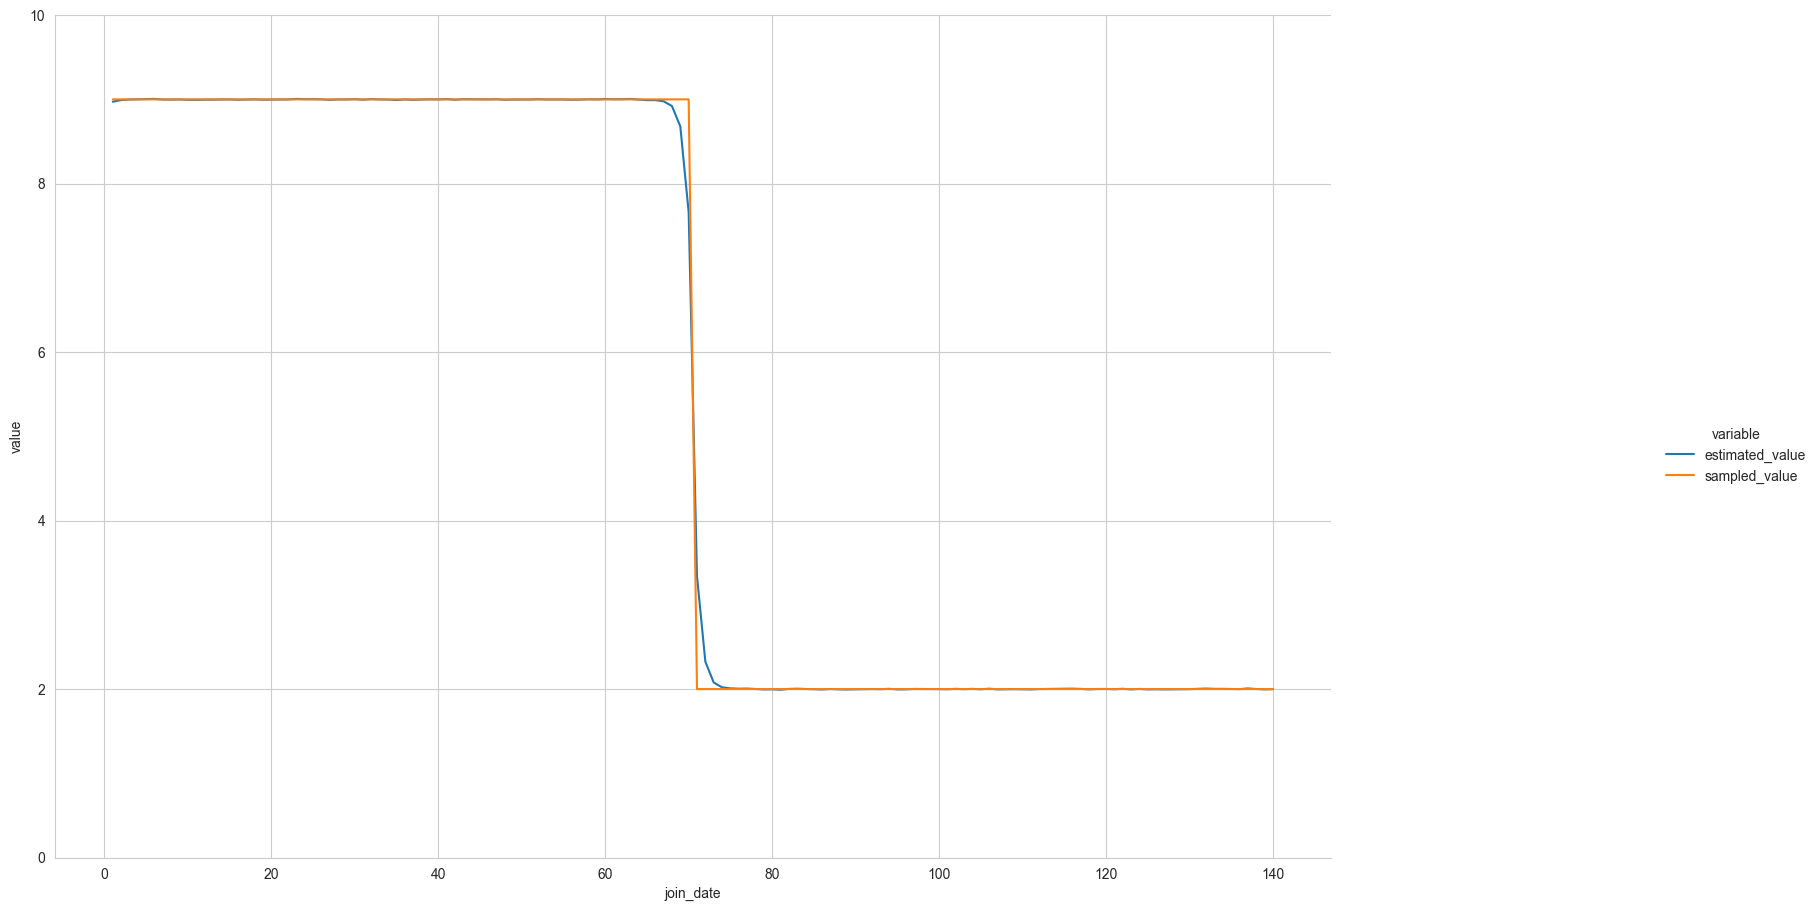

In [28]:
model_data = fit.to_frame()  # get the samples from the estimated distribution of each parameter to a pandas DF

# Get the average and stddev of the estimates on each day
columns_ = model_data.reset_index().columns
columns_ = [x for x in columns_ if 'nu' in x]
simp_model_data = model_data[columns_]
avgs = np.mean(simp_model_data, axis=0).values
stddevs = np.std(simp_model_data, axis=0).values
simp_model_data = pd.DataFrame(
    {
        'join_date': step_time_series_data['join_date'],
        'estimated_value': avgs,
        'stddev': stddevs
    },
    columns=['join_date', 'estimated_value', 'stddev']
)

# create a data to plot the estimated value, the observed value, and the 'true' value
plot_data = pd.merge(step_time_series_data, simp_model_data, on='join_date')
plot_data = plot_data[['join_date', 'estimated_value', 'sampled_value']]
plot_data = pd.melt(plot_data, id_vars='join_date', value_vars=['estimated_value', 'sampled_value'])

g = sns.relplot(plot_data, x='join_date', y='value', hue='variable', kind='line', facet_kws={'ylim': [0, 10]})
g.figure.set_size_inches(20, 10)

If the model were not seeing the data from the 'future', then the estimates wouldn't have decreased before the step change. This doesn't mean the model is incorrect, just that one shouldn't use the LTV predictions from days 1 to N-1 to assess the model performance. No, for that, we have to repeat this process each day, which is time-consuming

## 7- An equivalent model in PyMC

PyMC is a probabilistic programming library for Python, also widely used in the industry as previously presented in PyData London 2022 by Thomas Wiecki (https://www.youtube.com/watch?v=twpZhNqVExc). 
While PyMC can be better depending on how you can configure it (PyMC can make use of GPU!), it also has some disadvantages that may be clear with this example. I will not name them, for now, to not bias you on my own opinion, so if through this example you didn't find any problem, go for it.

The steps are almost the same as with PySTAN, with just the first 2 changing order
1) prepare the data for PyMC
2) define the stan model
3) train the model (can take a long time, since it is estimate a distribution for each point)
4) visualize results

### 7.1- Preparing the data for PyMC

To prepare the data for PyMC, there are 2 treatments we need to do
1) Set the data values to pytensor, and
2) Define a dictionary that will pass to PyMC that the data is temporal. The dictionary will have the key 'steps' that will be used afterward by the variables. The name itself isn't relevant but has to be the same in the dictionary and the PyMC distributions

### 7.2- The PyMC Model
We define the same model as before but in the PyMC API.
- Similar to PySTAN, we need to define priors for our variables
- In PyMC, the observed values need to be clarified by passing the values by making use of the input `observed`
- the temporal property of the model also has to be defined in each of the relevant variables through the input `dims`, which needs to be a string that matches the key of the dictionary we prepared before
- the name you see after each variable such as `'sigma'` in `pm.HalfCauchy("sigma", 2, observed=dev_t, dims="steps")` has to match the Python variable


In [29]:
# Define the coordinates for the time series
from scipy.linalg import cholesky
import pytensor.tensor as pt
import arviz as az

# create the dictionary that defines the temporal dimension to the model
coords = {"steps": test_time_series_data['date'].values}

with pm.Model(coords=coords) as model:
    y_t = pm.ConstantData("y_t", test_time_series_data['avg_prediction'].values)
    dev_t = pm.ConstantData("dev_t", test_time_series_data['total_sd_prediction'].values)

    # Priors on Gaussian random walks
    alpha_prior = pm.Normal.dist(6, 3)
    alpha_dev = pm.HalfCauchy('alpha_dev', 2)
    # dont need shape if defined dims
    alpha = pm.GaussianRandomWalk(
        "alpha", mu=0, sigma=alpha_dev, init_dist=alpha_prior, dims="steps"
    )

    # Likelihood
    likelihood = pm.Normal("likelihood", mu=alpha, sigma=dev_t, observed=y_t, dims="steps")

    # MCMC sampling
    trace = pm.sample(1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_dev, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain <xarray.DataArray 'chain' ()>
array(0)
Coordinates:
    chain    int64 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(1)
Coordinates:
    chain    int64 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(2)
Coordinates:
    chain    int64 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(3)
Coordinates:
    chain    int64 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept`

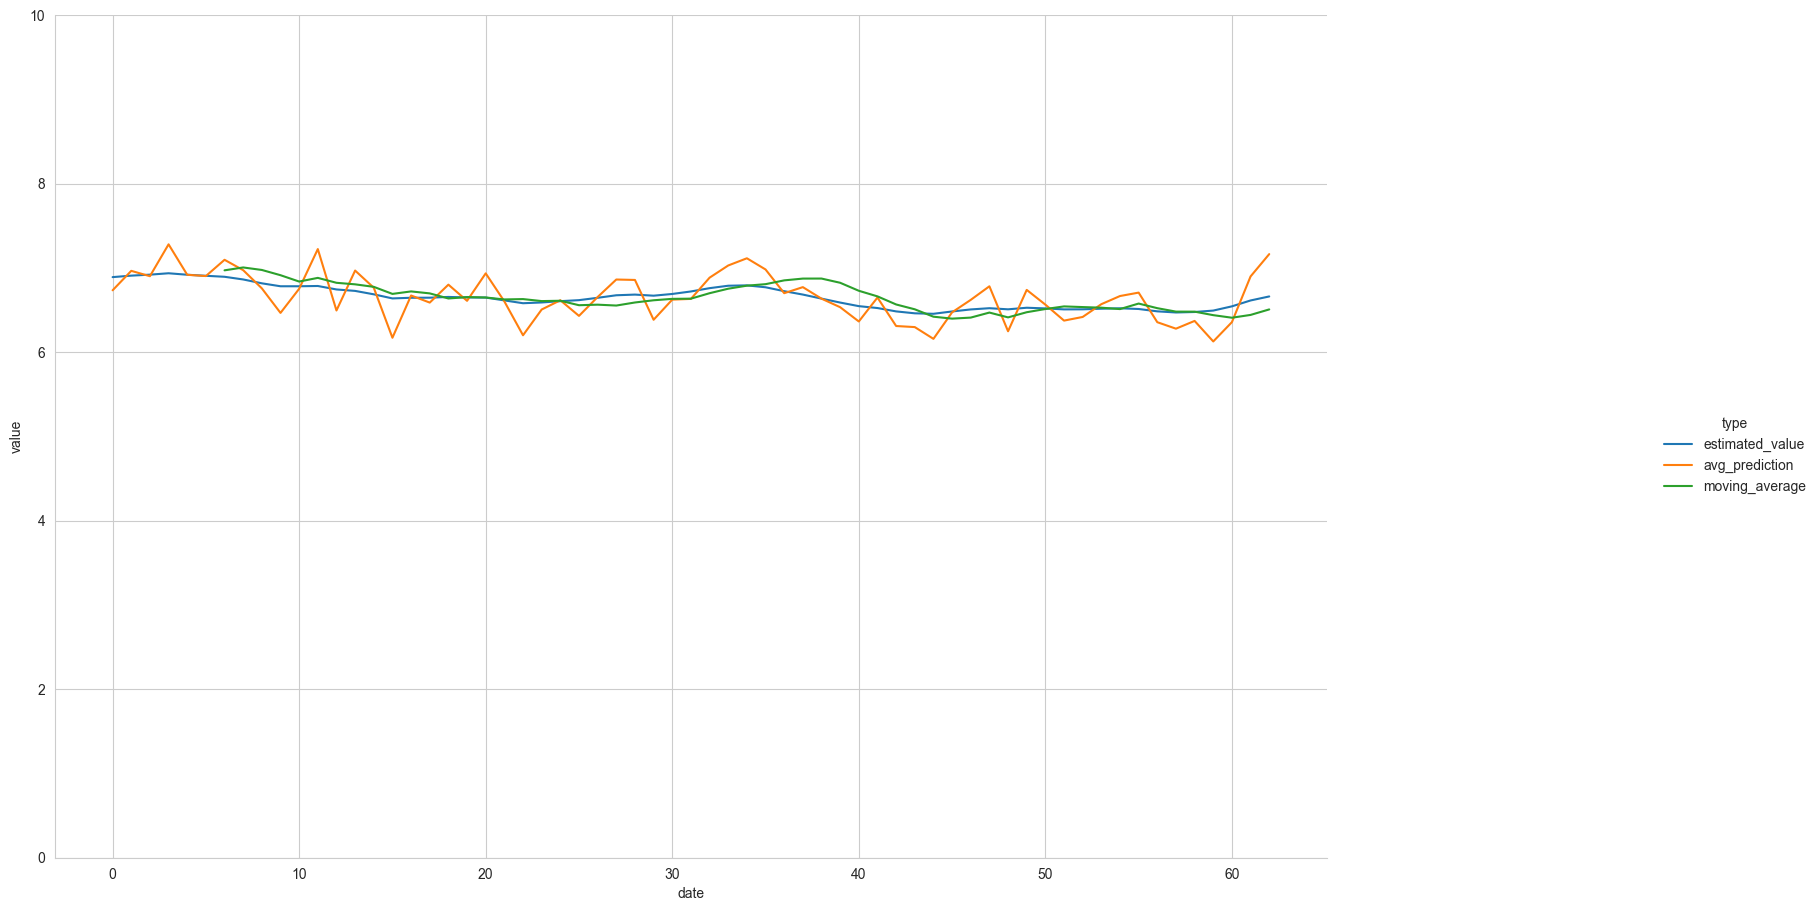

In [30]:
avgs = np.mean(np.mean(trace['posterior']['alpha'], axis=1), axis=0)


plot_data = pd.DataFrame(
    {
        'date': test_time_series_data['date'],
        'estimated_value': avgs
    },
    columns=['date', 'estimated_value']
)


plot_data = pd.DataFrame(
    {
        'date': test_time_series_data['date'],
        'estimated_value': avgs
    },
    columns=['date', 'estimated_value']
)

# create a data to plot the estimated value, the observed value, and the 'true' value
plot_data = pd.merge(test_time_series_data, plot_data, on='date')
# create a moving average as a reference
plot_data['moving_average'] = plot_data.sort_values('date')['avg_prediction'].rolling(window=7).mean()
plot_data = plot_data[['date', 'estimated_value', 'avg_prediction', 'moving_average']]
plot_data = pd.melt(plot_data, id_vars='date', value_vars=['estimated_value', 'avg_prediction', 'moving_average'], value_name='value', var_name='type')


g = sns.relplot(plot_data, x='date', y='value', hue='type', kind='line', facet_kws={'ylim': [0, 10]})
g.figure.set_size_inches(20, 10)